# Evaluating machine learning models

Machine learning involves automatically learning how to compute functions from examples.  There are several ways that this process can go wrong, including:

0. Overfitting to the training examples,
1. Optimizing for the wrong objective,
2. Starting with the wrong features,
3. Data drift (treated in another notebook),
4. ...


In [1]:
import pandas as pd
data = pd.read_parquet("data/training.parquet")

# Overfitting

The first concern we'd like to address is _overfitting_, in which we have a model whose performance on training examples is materially different from its performance in production.  We'll see that in action with a simple example.  First, let's choose some of our data as training examples:

In [2]:
overfit_training = data.sample(1000)
overfit_training.head(10)

,index,label,text
31728,11728,spam,All I found was 1/10 the size and convenience....
28660,8660,spam,"I'm not really *that* picky.No texture, or mor..."
3580,3580,legitimate,"With their wealth, their views increased; thei..."
21472,1472,spam,"It reminded me of kombucha, in a bad way. This..."
12507,12507,legitimate,I was hoping that the new recipe is terrible! ...
12791,12791,legitimate,"She had thought her wretchedly altered, and in..."
16693,16693,legitimate,I wanted to throw up pieces of paper. Harriet ...
25684,5684,spam,As soon as you receive your merchandise. They ...
741,741,legitimate,"You will not be sorry when it was no worse, sh..."
27499,7499,spam,I definitely feel more limber and alert when I...


We'll "train" a very simple "model" from these examples:  we'll just memorize hashes of every example so we can look up whether a given example is legitimate or not.  We'll program defensively, too:  if we don't find an example in either set, we'll call it legitimate if it has an even number of characters.

In [3]:
class OverfittingSpamModel(object):
    def __init__(self):
        self.legit = set()
        self.spam = set()
    
    def fit(self, df):
        for tup in df.itertuples():
            if tup.label == "legitimate":
                self.legit.add(hash(tup.text))
            else:
                self.spam.add(hash(tup.text))
    
    def predict(self, text):
        h = hash(text)
        if h in self.legit:
            return "legitimate"
        elif h in self.spam:
            return "spam"
        else:
            return (len(text) % 2 == 0) and "legitimate" or "spam"

osm = OverfittingSpamModel()
osm.fit(overfit_training)

We can try this out with some of our training examples to see how well it works:

In [4]:
for row in overfit_training.sample(10).itertuples():
    print("text is '%s...': actual label is %s; predicted label is %s" % (row.text[0:20], row.label, osm.predict(row.text)))

text is 'True, upon my honour...': actual label is legitimate; predicted label is legitimate
text is 'When I first heard a...': actual label is spam; predicted label is spam
text is 'Tinyada doesn't get ...': actual label is spam; predicted label is spam
text is 'How have I been to y...': actual label is legitimate; predicted label is legitimate
text is 'I use it daily on al...': actual label is legitimate; predicted label is legitimate
text is 'I love the convenien...': actual label is spam; predicted label is spam
text is 'He begged to know fu...': actual label is legitimate; predicted label is legitimate
text is 'Hardly any taste. Af...': actual label is spam; predicted label is spam
text is 'He could tell her no...': actual label is legitimate; predicted label is legitimate
text is 'But if she _did_, th...': actual label is legitimate; predicted label is legitimate


This model appears to work really well!  We can test it on the whole set of examples:

In [5]:
def model_accuracy(osm, df):
    correct = 0
    incorrect = 0
    for row in df.itertuples():
        if row.label == osm.predict(row.text):
            correct += 1
        else:
            incorrect += 1
    
    if correct + incorrect == 0:
        return 100
    
    return (float(correct) / float(correct + incorrect) * 100)

In [6]:
model_accuracy(osm, overfit_training)

100.0

Our model is enormously successful!  It has one hundred percent accuracy.  We probably expected this result, but it's always nice when things work out as you expected they would.  Let's see how well our model has generalized to data it _hasn't_ seen by testing it on the rest of our dataset (39,000 more examples).

In [7]:
model_accuracy(osm, data)

51.67

Uh oh!  It appears that our model is not much better than a coin toss once it's running on data it hasn't already seen.  If we had put this model in production, our application surely wouldn't have performed well.

We want a way to identify this problem before we put a model into production, and you've essentially seen it already:  when we train a model, we don't use all of the data we have available to us.  Instead, we divide our examples into distinct _training_ and _test_ sets, usually with about 70% of the examples in the former and 30% in the latter.  
The training algorithm only considers the examples in the training set.  After training our model, we can evaluate its performance on both the training set (which it saw during training) and the test set (which it didn't).  If the performance is materially different on the different sets, we know that we've overfit the data when training our model.

Next up, we'll deal with the question of what metrics we should use to evaluate our performance.  We used accuracy above, but is it always the best option?

# Evaluation metrics and types of error

Our training data set is _balanced_ between classes -- there are equal numbers of legitimate and spam documents.  But data in the real world are typically not balanced, and are often wildly unbalanced.  For example:

- The worldwide incidence of Rh-negative blood types is approximiately 6 percent;
- Between one and three percent of actual consumer payments transactions are fraudulent; and
- A rare disease may have an incidence rate on the order of one in ten thousand per year.

In cases like these, it would be possible to develop an accurate model that wouldn't produce meaningful results; for example:

- A blood type tester that always returned "Rh-positive" would be accurate roughly 94% of the time on a sufficiently diverse population;
- A fraud detector that always returned "not fradulent" would be accurate between 97-99% of the time -- until, that is, fraudsters determined that their charges would likely go through, increasing the rate of fraudulent charges; and
- A technique to screen for a very rare disease could be quite accurate by simply never identifying disease.

In many applications, we're not only interested in correctly identifying members of one class, we're interested in correctly identifying members of both classes.  We can capture this behavior by using better metrics than accuracy.

To learn about these metrics, let's start with an unbalanced data set, in which 90% of the messages are spam.

In [8]:
legit_sample = data[data.label == 'legitimate'].sample(2000)
spam_sample = data[data.label == 'spam'].sample(18000)
unbalanced = pd.DataFrame.append(legit_sample, spam_sample)

To avoid overfitting, we'll split the unbalanced data set into training and test sets, using functionality from scikit-learn.

In [9]:
from sklearn.model_selection import train_test_split
unbalanced_train, unbalanced_test = train_test_split(unbalanced, test_size=0.3)

We'll now create a simple model that should work pretty well for spam messages but not necessarily as well for legitimate ones.  

In [10]:
from collections import defaultdict
import re
    
class SensitiveSpamModel(object):
    
    def __init__(self):
        self.legit = set()
        self.spam = set()
    
    def fit(self, df):
        """ Train a model based on the most frequent unique 
            words in each class of documents """
        legit_words = defaultdict(lambda: 0)
        spam_words = defaultdict(lambda: 0)
        
        for tup in df.itertuples():
            target = spam_words
            if tup.label == "legitimate":
                target = legit_words
            for word in re.split(r"\W+", tup.text):
                if len(word) > 0:
                    target[word.lower()] += 1
        
        # remove words common to both classes
        for word in set(legit_words.keys()).intersection(set(spam_words.keys())):
            del legit_words[word]
            del spam_words[word]
        
        top_legit_words = sorted(legit_words.items(), key=lambda kv: kv[1], reverse=True)
        top_spam_words = sorted(spam_words.items(), key=lambda kv: kv[1], reverse=True)
        
        # store ten times as many words from the spam set
        self.legit = set([t[0] for t in top_legit_words[:100]])
        self.spam = set([t[0] for t in top_spam_words[:1000]])
            
    def predict(self, text):
        legit_score = 0
        spam_score = 0
        
        for word in re.split(r"\W+", text):
            w = word.lower()
            if word in self.legit:
                legit_score = legit_score + 1
            elif word in self.spam:
                spam_score = spam_score + 1
        
        # bias results towards spam in the event of ties
        return (legit_score > spam_score) and "legitimate" or "spam"

ssm = SensitiveSpamModel()
ssm.fit(unbalanced_train)

Let's check the accuracy on our training sample.

In [11]:
model_accuracy(ssm, unbalanced_train)

94.30714285714285

To make sure we've not overfit our training sample, let's check the accuracy on the test sample.

In [12]:
model_accuracy(ssm, unbalanced_test)

92.9

That's not quite as good as the results on our training sample, but it's still pretty decent (that is, it's better than just always returning "spam" would be given the balance of the classes).  

However, we get a different picture if we look at our model's performance on the balanced data.

In [13]:
model_accuracy(ssm, data)

64.4725

And the accuracy is even worse if we look at a sample where the label balance is reversed (i.e., only 10% of documents are spam):

In [14]:
legit_sample = data[data.label == 'legitimate'].sample(900)
spam_sample = data[data.label == 'spam'].sample(100)
legit_biased = pd.DataFrame.append(legit_sample, spam_sample)
model_accuracy(ssm, legit_biased)

34.0

We'd like to understand the performance of our model with some metric that captures not only the overall accuracy but the accuracy for positive cases and the accuracy for negative cases.  That is, if we assume that our goal is to identify spam documents, we care about:

- _true positives_, which are spam documents that our model predicts as spam;
- _true negatives_, which are legitimate documents that our model predicts as legitimate;
- _false positives_, which are legitimate documents that our model predicts as spam; and
- _false negatives_, which are spam documents that our model predicts as legitimate

The proportions between these quantities can provide interesting metrics.  For example, the ratio of true positives to actual positives (that is, true positives + false negatives) is called _recall_, which indicates the percentage of spam documents we've selected.  The ratio of true positives to all predicted positives (that is, true positives + false positives) is called _precision_, which indicates the percentage of predicted spam documents that are actually spam.  Ideally, a good classifier would have both high precision and high recall, but in some applications either precision or recall is more important.

We can visualize the overall performance of a classifier with a _confusion matrix_, which plots actual labels in rows and predicted labels in columns.  The confusion matrix thus puts correct predictions along one diagonal and various kinds of incorrect predictions elsewhere.  Let's see one in action for our data.

In [15]:
from mlworkflows import plot

def true_and_predicted(df, model):
    return (df.label.values, [model.predict(txt) for txt in df.text.values])

df, chart = plot.binary_confusion_matrix(*true_and_predicted(unbalanced, ssm))

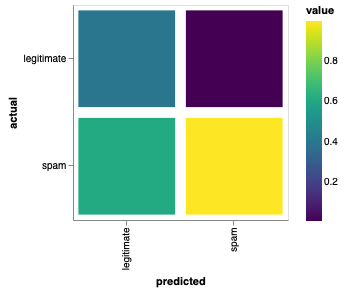

In [16]:
chart

In [17]:
df

,actual,predicted,raw_count,value
0,legitimate,legitimate,783,0.391500
1,spam,legitimate,1217,0.608500
2,legitimate,spam,6,0.000333
3,spam,spam,17994,0.999667
